# Create Spark Session

In [1]:
import os
import json
import shap
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mlflow
import tempfile
import mlflow.spark
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

from pyspark import SparkContext
from pyspark.sql import functions as F, Row
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, sum, when, round, expr, udf, lit
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType, BooleanType, IntegerType

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import VectorAssembler, VectorSlicer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier

from sklearn.metrics import f1_score, recall_score, precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")

/home/jihadakbr/venvs/loan_chatbot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
spark = SparkSession.builder.appName("CreditRisk").master("yarn").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/30 14:57:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/30 14:57:46 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
spark

# MLflow Tracking

In [4]:
# Set MLflow tracking URI (local)
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment("CreditRiskModeling")

<Experiment: artifact_location='/home/jihadakbr/Project/Home_Credit_Default_Risk/notebook/../mlruns/787990574769484173', creation_time=1755711395931, experiment_id='787990574769484173', last_update_time=1755711395931, lifecycle_stage='active', name='CreditRiskModeling', tags={}>

# Load the Train and Test Sets from HDFS

In [5]:
# default col is 25, I change it to 1000
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [6]:
train = spark.read.parquet("hdfs:///user/jihadakbr/credit_risk/ml_data/train.parquet")
test = spark.read.parquet("hdfs:///user/jihadakbr/credit_risk/ml_data/test.parquet")

In [7]:
row_count = train.count()
column_count = len(train.columns)

print(f"Shape: ({row_count}, {column_count})")

[Stage 2:=============================>                             (1 + 1) / 2]

Shape: (307499, 114)


In [8]:
row_count = test.count()
column_count = len(test.columns)

print(f"Shape: ({row_count}, {column_count})")

Shape: (48740, 114)


In [9]:
train.printSchema()

root
 |-- SK_ID_CURR: string (nullable = true)
 |-- TARGET: long (nullable = true)
 |-- NAME_CONTRACT_TYPE: long (nullable = true)
 |-- CODE_GENDER: long (nullable = true)
 |-- FLAG_OWN_CAR: long (nullable = true)
 |-- FLAG_OWN_REALTY: long (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- NAME_EDUCATION_TYPE: long (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: long (nullable = true)
 |-- DAYS_EMPLOYED: long (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: long (nullable = true)
 |-- OWN_CAR_AGE: double (nullable = true)
 |-- FLAG_MOBIL: long (nullable = true)
 |-- FLAG_WORK_PHONE: long (nullable = true)
 |-- FLAG_CONT_MOBILE: long (nullable = true)
 |-- FLAG_PHONE: long (nullable = true)
 |-- FLAG_EMAIL: long (nullable = true)
 |-- OCCUPATION_TYPE: double (nullable = true)
 |-- CNT_FAM_MEMBERS: d

In [10]:
test.printSchema()

root
 |-- SK_ID_CURR: string (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: long (nullable = true)
 |-- CODE_GENDER: long (nullable = true)
 |-- FLAG_OWN_CAR: long (nullable = true)
 |-- FLAG_OWN_REALTY: long (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- NAME_EDUCATION_TYPE: long (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: long (nullable = true)
 |-- DAYS_EMPLOYED: long (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: long (nullable = true)
 |-- OWN_CAR_AGE: double (nullable = true)
 |-- FLAG_MOBIL: long (nullable = true)
 |-- FLAG_WORK_PHONE: long (nullable = true)
 |-- FLAG_CONT_MOBILE: long (nullable = true)
 |-- FLAG_PHONE: long (nullable = true)
 |-- FLAG_EMAIL: long (nullable = true)
 |-- OCCUPATION_TYPE: double (nullable = true)
 |-- CNT_FAM_MEMBERS

In [11]:
train.select(train.columns[:10]).show(5)

+----------+------+------------------+-----------+------------+---------------+----------------+----------+-----------+-------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|NAME_EDUCATION_TYPE|
+----------+------+------------------+-----------+------------+---------------+----------------+----------+-----------+-------------------+
|    100002|     1|                 0|          0|           0|              1|        202500.0|  406597.5|    24700.5|                  1|
|    100003|     0|                 0|          1|           0|              0|        270000.0| 1293502.5|    35698.5|                  3|
|    100004|     0|                 1|          0|           1|              1|         67500.0|  135000.0|     6750.0|                  1|
|    100006|     0|                 0|          1|           0|              1|        135000.0|  312682.5|    29686.5|                  1|
|    100007|     0| 

In [12]:
test.select(test.columns[:10]).show(5)

[Stage 9:>                                                          (0 + 1) / 1]

+----------+------+------------------+-----------+------------+---------------+----------------+----------+-----------+-------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|NAME_EDUCATION_TYPE|
+----------+------+------------------+-----------+------------+---------------+----------------+----------+-----------+-------------------+
|    100001|  NULL|                 0|          1|           0|              1|        135000.0|  568800.0|    20560.5|                  3|
|    100005|  NULL|                 0|          0|           0|              1|         99000.0|  222768.0|    17370.0|                  1|
|    100013|  NULL|                 0|          0|           1|              1|        202500.0|  663264.0|    69777.0|                  3|
|    100028|  NULL|                 0|          1|           0|              1|        315000.0| 1575000.0|    49018.5|                  1|
|    100038|  NULL| 

# Check Missing Values

In [13]:
def missing_values_summary(df):
    null_counts = df.select([
        sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
    ])
    
    nulls = null_counts.first().asDict()
    total_missing = 0

    for col_name, null_count in nulls.items():
        if null_count > 0:
            print(f"Column '{col_name}': {null_count} missing values")
            total_missing += null_count

    if total_missing == 0:
        print("No missing values in any column.")

In [14]:
missing_values_summary(train)

[Stage 12:>                                                         (0 + 1) / 1]

No missing values in any column.


In [15]:
missing_values_summary(test)

[Stage 15:>                                                         (0 + 1) / 1]

Column 'TARGET': 48740 missing values


# Define the New Schema

In [16]:
# Convert boolean columns to double
train = train.withColumn("HIGH_CTI", F.col("HIGH_CTI").cast("double")) \
       .withColumn("HIGH_ATI", F.col("HIGH_ATI").cast("double")) \
       .withColumn("HIGH_GTI", F.col("HIGH_GTI").cast("double"))

# Convert boolean columns to double
test = test.withColumn("HIGH_CTI", F.col("HIGH_CTI").cast("double")) \
       .withColumn("HIGH_ATI", F.col("HIGH_ATI").cast("double")) \
       .withColumn("HIGH_GTI", F.col("HIGH_GTI").cast("double"))

In [17]:
# # Get the original schema
# original_schema = train.schema

# # Create a new schema with nullable = False for all columns
# new_schema = StructType([
#     StructField(field.name, field.dataType, nullable=False)
#     for field in original_schema
# ])

In [18]:
# # Recreate DataFrames using full schema (preserving all columns)
# train = spark.createDataFrame(train.rdd, schema=new_schema)
# test = spark.createDataFrame(test.rdd, schema=new_schema)

In [19]:
test = test.drop("TARGET")

In [20]:
train.printSchema()

root
 |-- SK_ID_CURR: string (nullable = true)
 |-- TARGET: long (nullable = true)
 |-- NAME_CONTRACT_TYPE: long (nullable = true)
 |-- CODE_GENDER: long (nullable = true)
 |-- FLAG_OWN_CAR: long (nullable = true)
 |-- FLAG_OWN_REALTY: long (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- NAME_EDUCATION_TYPE: long (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: long (nullable = true)
 |-- DAYS_EMPLOYED: long (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: long (nullable = true)
 |-- OWN_CAR_AGE: double (nullable = true)
 |-- FLAG_MOBIL: long (nullable = true)
 |-- FLAG_WORK_PHONE: long (nullable = true)
 |-- FLAG_CONT_MOBILE: long (nullable = true)
 |-- FLAG_PHONE: long (nullable = true)
 |-- FLAG_EMAIL: long (nullable = true)
 |-- OCCUPATION_TYPE: double (nullable = true)
 |-- CNT_FAM_MEMBERS: d

In [21]:
test.printSchema()

root
 |-- SK_ID_CURR: string (nullable = true)
 |-- NAME_CONTRACT_TYPE: long (nullable = true)
 |-- CODE_GENDER: long (nullable = true)
 |-- FLAG_OWN_CAR: long (nullable = true)
 |-- FLAG_OWN_REALTY: long (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- NAME_EDUCATION_TYPE: long (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: long (nullable = true)
 |-- DAYS_EMPLOYED: long (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: long (nullable = true)
 |-- OWN_CAR_AGE: double (nullable = true)
 |-- FLAG_MOBIL: long (nullable = true)
 |-- FLAG_WORK_PHONE: long (nullable = true)
 |-- FLAG_CONT_MOBILE: long (nullable = true)
 |-- FLAG_PHONE: long (nullable = true)
 |-- FLAG_EMAIL: long (nullable = true)
 |-- OCCUPATION_TYPE: double (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- REGION_

# Vector Assembler

In [22]:
# Feature selection
feature_cols = [c for c in train.columns if c not in ['SK_ID_CURR', 'TARGET']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Handling class imbalance

In [23]:
# Calculate class weights
pos_count = train.filter(F.col("TARGET") == 1).count()
neg_count = train.count() - pos_count
weight_ratio = neg_count / pos_count if pos_count > 0 else 1.0
train = train.withColumn("weight", F.when(F.col("TARGET") == 1, weight_ratio).otherwise(1))

# Model Building

In [24]:
models = {
    "Random Forest": RandomForestClassifier(
        featuresCol="features",
        labelCol="TARGET",
        weightCol="weight",
        numTrees=50,           
        maxDepth=6,            
        maxBins=32,
        subsamplingRate=0.8,   
        featureSubsetStrategy="sqrt",
        seed=42
    ),
    "GBT": GBTClassifier(
        featuresCol="features",
        labelCol="TARGET",
        weightCol="weight",
        maxIter=30,
        maxDepth=4,
        stepSize=0.1,
        minInstancesPerNode=100,
        seed=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        featuresCol="features",
        labelCol="TARGET",
        weightCol="weight",
        maxDepth=6,
        minInstancesPerNode=100,
        maxBins=32,
        seed=42
    )
}

# Splitting the Dataset

In [25]:
# Stratified train/validation split
fractions = {0: 0.8, 1: 0.8}  # Same fraction for both classes
train_data = train.sampleBy("TARGET", fractions, seed=42)
val_data = train.subtract(train_data)

In [26]:
# Evaluation function with AUC-ROC
def evaluate_model(model, val_data, model_name):
    start_time = time.time()
    
    # Predict
    predictions = model.transform(val_data)
    
    # AUC-ROC
    roc_evaluator = BinaryClassificationEvaluator(
        labelCol="TARGET",
        rawPredictionCol="rawPrediction",
        metricName="areaUnderROC"
    )
    roc_auc = roc_evaluator.evaluate(predictions)
    
    # Confusion matrix at default threshold (0.5)
    confusion = predictions.groupBy("TARGET", "prediction").count().collect()
    tp = fp = fn = 0
    for row in confusion:
        if row['TARGET'] == 1 and row['prediction'] == 1:
            tp = row['count']
        elif row['TARGET'] == 0 and row['prediction'] == 1:
            fp = row['count']
        elif row['TARGET'] == 1 and row['prediction'] == 0:
            fn = row['count']
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    elapsed = time.time() - start_time
    
    print(f"\n{model_name} Results:")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Evaluation Time: {elapsed:.1f}s")
    
    return {
        "model": model,
        "roc_auc": roc_auc,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

In [27]:
results = {}
with mlflow.start_run():
    for model_name, classifier in models.items():
        print(f"{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}")
        
        try:
            # Start nested run for each model
            with mlflow.start_run(nested=True, run_name=model_name):
                # Log parameters
                mlflow.log_param("model_type", model_name)
                mlflow.log_param("num_features", len(feature_cols))
                
                # Create pipeline
                pipeline = Pipeline(stages=[assembler, classifier])
                
                # Train with timing
                train_start = time.time()
                model = pipeline.fit(train_data)
                train_time = time.time() - train_start
                
                # Evaluate
                eval_results = evaluate_model(model, val_data, model_name)
                if eval_results:
                    eval_results["train_time"] = train_time
                    results[model_name] = eval_results
                    
                    # Log metrics
                    mlflow.log_metrics({
                        "roc_auc": eval_results["roc_auc"],
                        "recall": eval_results["recall"],
                        "precision": eval_results["precision"],
                        "f1": eval_results["f1"],
                        "train_time": train_time
                    })
                    
                    # Log model
                    mlflow.spark.log_model(model, f"{model_name}_model")
                    
                    print(f"Training Time: {train_time:.1f}s")
        
        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            continue

Training Random Forest



Random Forest Results:
AUC-ROC: 0.7312
Recall: 0.6641
Precision: 0.1555
F1 Score: 0.2520
Evaluation Time: 53.0s


2025/08/30 15:02:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 73.4s
Training GBT



GBT Results:
AUC-ROC: 0.7419
Recall: 0.6690
Precision: 0.1588
F1 Score: 0.2567
Evaluation Time: 29.6s


2025/08/30 15:04:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 94.2s
Training Decision Tree



Decision Tree Results:
AUC-ROC: 0.5450
Recall: 0.6611
Precision: 0.1458
F1 Score: 0.2389
Evaluation Time: 24.5s


2025/08/30 15:06:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Time: 20.3s


# The Best Model

In [28]:
# Get best model from results
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = results[best_model_name]['model']
print(f"Best Model: {best_model_name} (AUC-ROC: {results[best_model_name]['roc_auc']:.4f})")

Best Model: GBT (AUC-ROC: 0.7419)


## Feature Importance

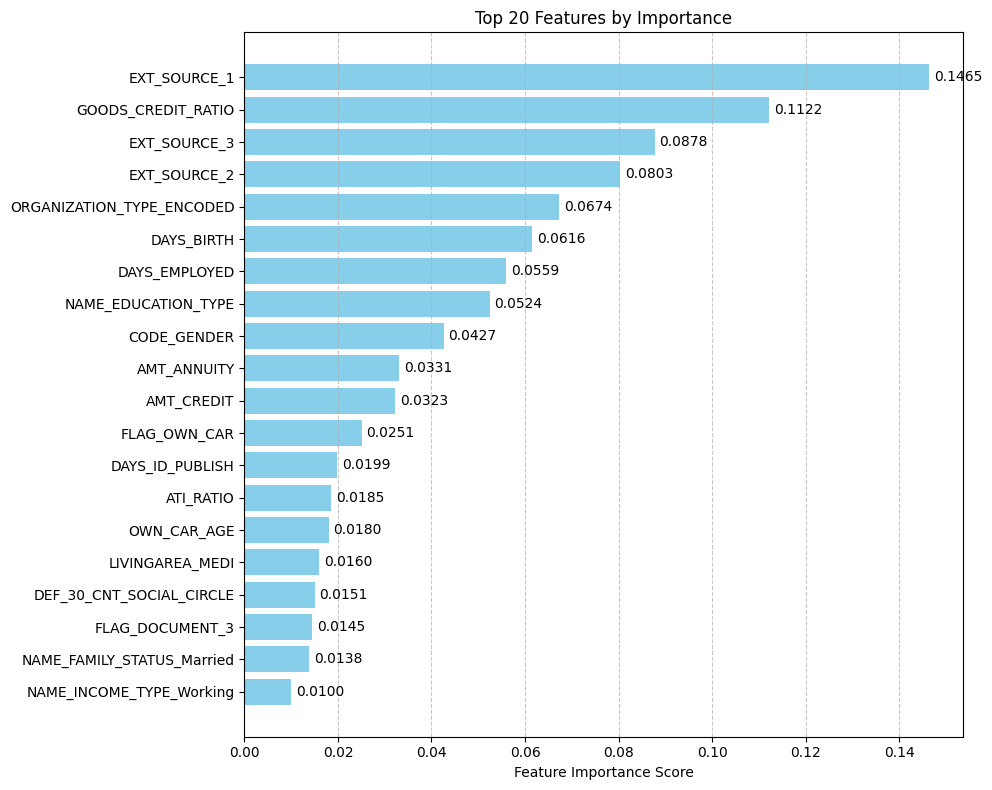

2025/08/30 15:06:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Top 20 Features by Importance:
EXT_SOURCE_1                            : 0.146457
GOODS_CREDIT_RATIO                      : 0.112214
EXT_SOURCE_3                            : 0.087756
EXT_SOURCE_2                            : 0.080326
ORGANIZATION_TYPE_ENCODED               : 0.067367
DAYS_BIRTH                              : 0.061592
DAYS_EMPLOYED                           : 0.055926
NAME_EDUCATION_TYPE                     : 0.052435
CODE_GENDER                             : 0.042655
AMT_ANNUITY                             : 0.033122
AMT_CREDIT                              : 0.032259
FLAG_OWN_CAR                            : 0.025099
DAYS_ID_PUBLISH                         : 0.019874
ATI_RATIO                               : 0.018547
OWN_CAR_AGE                             : 0.018031
LIVINGAREA_MEDI                         : 0.015960
DEF_30_CNT_SOCIAL_CIRCLE                : 0.015069
FLAG_DOCUMENT_3                         : 0.014506
NAME_FAMILY_STATUS_Married              : 0.013826

In [29]:
# Extract feature importances
classifier_model = best_model.stages[-1]

# Feature importance
if hasattr(classifier_model, 'featureImportances'):
    feature_importances = classifier_model.featureImportances
    feature_names = assembler.getInputCols()
    
    features_importance = [(feature, feature_importances[i]) 
                         for i, feature in enumerate(feature_names)]
    
    sorted_features = sorted(features_importance, key=lambda x: x[1], reverse=True)
    top_20_features = [feat for feat, imp in sorted_features[:20]]
    top_20_importances = [imp for feat, imp in sorted_features[:20]]
    
    plt.figure(figsize=(10, 8))
    y_pos = np.arange(len(top_20_features))
    plt.barh(y_pos, top_20_importances, align='center', color='skyblue')
    plt.yticks(y_pos, labels=top_20_features)
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance Score')
    plt.title('Top 20 Features by Importance')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    for i, v in enumerate(top_20_importances):
        plt.text(v + 0.001, i, f"{v:.4f}", color='black', va='center')
    plt.tight_layout()
    # plt.savefig("/tmp/feature_importance.png")
    plt.show()
    plt.close()

    with mlflow.start_run(nested=True, run_name="Best_Model"):
        # Log metrics
        mlflow.log_metrics({
            "roc_auc": results[best_model_name]['roc_auc'],
            "f1": results[best_model_name]['f1'],
            "recall": results[best_model_name]['recall'],
            "precision": results[best_model_name]['precision']
        })
        
        # Log parameters
        mlflow.log_params({
            "best_model_type": best_model_name,
            "num_features": len(feature_cols)
        })
        
        # Log model
        mlflow.spark.log_model(best_model, "best_model")
        
        # Log artifacts
        # mlflow.log_artifact("/tmp/feature_importance.png")
        mlflow.log_param("top_20_features", json.dumps(top_20_features))

    
    print("\n" + "="*50)
    print("Top 20 Features by Importance:")
    for feat, imp in sorted_features[:20]:
        print(f"{feat:<40}: {imp:.6f}")
    print("="*50 + "\n")
else:
    print(f"Model {best_model_name} doesn't support feature importances")
    top_20_features = None

## Retraining with Top 20 Features

In [30]:
if top_20_features:
    top_20_assembler = VectorAssembler(inputCols=top_20_features, outputCol="features")

    # Get original classifier
    original_classifier = models[best_model_name]
    
    if isinstance(original_classifier, GBTClassifier):
        gbt_params = {
            'maxIter': original_classifier.getMaxIter(),
            'maxDepth': original_classifier.getMaxDepth(),
            'stepSize': original_classifier.getStepSize(),
            'minInstancesPerNode': original_classifier.getMinInstancesPerNode(),
            'seed': original_classifier.getSeed()
        }
        new_classifier = GBTClassifier(
            featuresCol="features",
            labelCol="TARGET",
            weightCol="weight",
            **gbt_params
        )
    else:
        param_map = original_classifier.extractParamMap()
        exclude_params = {'featuresCol', 'labelCol', 'weightCol', 'rawPredictionCol'}
        params = {param.name: value for param, value in param_map.items() 
                 if param.name not in exclude_params}
        new_classifier = original_classifier.__class__(
            featuresCol="features",
            labelCol="TARGET",
            weightCol="weight",
            **params
        )
    
    top20_pipeline = Pipeline(stages=[top_20_assembler, new_classifier])
    top20_model = top20_pipeline.fit(train_data)

    print("Evaluating top-20 model...")
    val_data_top20 = val_data.select(['SK_ID_CURR', 'TARGET', 'weight'] + top_20_features)
    top20_results = evaluate_model(top20_model, val_data_top20, f"{best_model_name} (Top 20 Features)")    

    # MLflow
    with mlflow.start_run(nested=True, run_name="Top20_Model"):
        mlflow.log_metrics({
            "top20_roc_auc": top20_results["roc_auc"],
            "top20_f1": top20_results["f1"]
        })
        
        mlflow.log_params({
            "top20_feature_count": len(top_20_features),
            "original_model": best_model_name
        })
        
        mlflow.spark.log_model(top20_model, "top20_model")
        mlflow.log_param("top20_features", json.dumps(top_20_features))

Evaluating top-20 model...



GBT (Top 20 Features) Results:
AUC-ROC: 0.7424
Recall: 0.6689
Precision: 0.1593
F1 Score: 0.2573
Evaluation Time: 27.0s


2025/08/30 15:08:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Interpretation of AUC-ROC

The AUC-ROC score measures how well the model can distinguish between two groups:
- Positive class: borrowers who will default.
- Negative class: borrowers who will repay.
- AUC = 0.5 → performance equal to random guessing.
- AUC = 1.0 → perfect separation of defaulters and non-defaulters.

With an AUC of 0.7424, the model has moderate discriminatory power. In practical terms, when comparing a random defaulter and a random non-defaulter, the model has a 74.24% chance of correctly ranking the defaulter as higher risk than the non-defaulter. Conversely, it also means it has a 74.24% chance of correctly ranking the non-defaulter as lower risk than the defaulter.

This result indicates that the model is substantially better than chance and can rank borrowers by risk with useful accuracy. In credit scoring practice, AUC values between 0.7 and 0.8 are generally considered good, though not perfect.

In [31]:
# Show what the model actually sees during transformation
sample_output = top20_model.transform(val_data_top20.limit(1))

print("Columns used in transformation:")
print(sample_output.columns)

print("\nFeature vector schema:")
print(sample_output.schema["features"].metadata)

Columns used in transformation:
['SK_ID_CURR', 'TARGET', 'weight', 'EXT_SOURCE_1', 'GOODS_CREDIT_RATIO', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'ORGANIZATION_TYPE_ENCODED', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'AMT_ANNUITY', 'AMT_CREDIT', 'FLAG_OWN_CAR', 'DAYS_ID_PUBLISH', 'ATI_RATIO', 'OWN_CAR_AGE', 'LIVINGAREA_MEDI', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS_Married', 'NAME_INCOME_TYPE_Working', 'features', 'rawPrediction', 'probability', 'prediction']

Feature vector schema:
{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'EXT_SOURCE_1'}, {'idx': 1, 'name': 'GOODS_CREDIT_RATIO'}, {'idx': 2, 'name': 'EXT_SOURCE_3'}, {'idx': 3, 'name': 'EXT_SOURCE_2'}, {'idx': 4, 'name': 'ORGANIZATION_TYPE_ENCODED'}, {'idx': 5, 'name': 'DAYS_BIRTH'}, {'idx': 6, 'name': 'DAYS_EMPLOYED'}, {'idx': 7, 'name': 'NAME_EDUCATION_TYPE'}, {'idx': 8, 'name': 'CODE_GENDER'}, {'idx': 9, 'name': 'AMT_ANNUITY'}, {'idx': 10, 'name': 'AMT_CREDIT'}, {'idx': 11, 'n

# Model Predictions on the Test Set

In [32]:
try:
    ### top20_model = top20_pipeline.fit(train_data) ###
    ### raw_predictions = top20_model.transform(test) = top20_pipeline.fit(train_data).transform(test) ###
    raw_predictions = top20_model.transform(test)
    
    final_predictions = spark.createDataFrame(
        raw_predictions.select("SK_ID_CURR", "prediction").rdd,
        schema=StructType([
            StructField("SK_ID_CURR", StringType(), False),
            StructField("TARGET", DoubleType(), True)
        ])
    ).withColumnRenamed("prediction", "TARGET")
    
    final_predictions = final_predictions.na.fill(0.0, ["TARGET"])
    
    print("Sample predictions:")
    final_predictions.show(5)
    print("Null values after handling:", 
          final_predictions.filter(col("TARGET").isNull()).count())
    
    # Save predictions
    final_predictions.write.mode("overwrite").parquet(
        "hdfs:///user/jihadakbr/credit_risk/prediction/prediction_on_test_set"
    )
    
except Exception as e:
    print(f"Prediction failed: {str(e)}")
    print("Trying fallback approach...")
    
    local_data = top20_model.transform(test.limit(1000)) \
              .select("SK_ID_CURR", "prediction") \
              .collect()
    
    fallback_data = [(row['SK_ID_CURR'], float(row['prediction']) 
                     if row['prediction'] is not None else 0.0) 
                     for row in local_data]
    
    fallback_df = spark.createDataFrame(
        fallback_data,
        ["SK_ID_CURR", "TARGET"]
    )
    fallback_df.show()

Sample predictions:


+----------+------+
|SK_ID_CURR|TARGET|
+----------+------+
|    100001|   0.0|
|    100005|   1.0|
|    100013|   0.0|
|    100028|   0.0|
|    100038|   1.0|
+----------+------+
only showing top 5 rows

Null values after handling: 0


In [33]:
# Check the result in HDFS
!hdfs dfs -ls /user/jihadakbr/credit_risk/prediction/prediction_on_test_set

Found 2 items
-rw-r--r--   1 jihadakbr supergroup          0 2025-08-30 15:08 /user/jihadakbr/credit_risk/prediction/prediction_on_test_set/_SUCCESS
-rw-r--r--   1 jihadakbr supergroup     225986 2025-08-30 15:08 /user/jihadakbr/credit_risk/prediction/prediction_on_test_set/part-00000-8c7f1f08-c689-4b2b-9bf9-e54885399f37-c000.snappy.parquet


# Read the Saved File from HDFS

In [34]:
# Read the Parquet file into a DataFrame
xf = spark.read.parquet("hdfs:///user/jihadakbr/credit_risk/prediction/prediction_on_test_set")

# Show the first few rows
xf.show()

+----------+------+
|SK_ID_CURR|TARGET|
+----------+------+
|    100001|   0.0|
|    100005|   1.0|
|    100013|   0.0|
|    100028|   0.0|
|    100038|   1.0|
|    100042|   0.0|
|    100057|   0.0|
|    100065|   0.0|
|    100066|   0.0|
|    100067|   1.0|
|    100074|   0.0|
|    100090|   0.0|
|    100091|   1.0|
|    100092|   1.0|
|    100106|   0.0|
|    100107|   1.0|
|    100109|   0.0|
|    100117|   0.0|
|    100128|   1.0|
|    100141|   0.0|
+----------+------+
only showing top 20 rows



# Save the Model

**Save the Best Model**

In [35]:
model_save_path = "hdfs:///user/jihadakbr/credit_risk/ml_model/saved_model"
# top20_model.save(model_save_path)
top20_model.write().overwrite().save(model_save_path)

In [36]:
with mlflow.start_run(run_name="Production_Model") as run:
    # Save model to MLflow
    mlflow.spark.log_model(top20_model, "production_model")
    
    # Log parameters and features
    mlflow.log_params({
        "model_type": "Production",
        "top_features": str(top_20_features),  # Convert list to string for logging
        "best_model": best_model_name
    })
    
    # Log schema
    input_schema = train_data.select(top_20_features).schema
    with tempfile.NamedTemporaryFile(suffix=".json") as tmp:
        tmp.write(input_schema.json().encode())
        tmp.flush()
        mlflow.log_artifact(tmp.name, "schema")
        
    print(f"Model saved to MLflow with Run ID: {run.info.run_id}")

2025/08/30 15:09:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved to MLflow with Run ID: 37d2cbaaf3c94eceb7e1a1bc2f09d9ea


**Save the Feature Columns List**

In [37]:
# Create deployment directory
!mkdir -p /home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment

In [38]:
with open('/home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/feature_columns.json', 'w') as f:
    json.dump(top_20_features, f)

**Save the Preprocessing Pipeline**

In [39]:
pipeline_model = PipelineModel(stages=[top_20_assembler, top20_model.stages[-1]])
pipeline_save_path = "hdfs:///user/jihadakbr/credit_risk/ml_model/pipeline_model"
pipeline_model.write().overwrite().save(pipeline_save_path)

**Save Schema Information**

In [40]:
input_schema = train_data.select(top_20_features).schema
with open('/home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/input_schema.json', 'w') as f:
    f.write(input_schema.json())

**Package for Deployment**

In [41]:
# Download model from HDFS to local
!hdfs dfs -get /user/jihadakbr/credit_risk/ml_model/saved_model /home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/

get: `/home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/saved_model/metadata/_SUCCESS': File exists
get: `/home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/saved_model/metadata/part-00000': File exists


In [42]:
# Create requirements file
!pip freeze > /home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/requirements.txt

In [43]:
# First path: output file; Second path: source folder
!zip -r /home/jihadakbr/Project/Home_Credit_Default_Risk/archive/model_deployment.zip  /home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/

updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/ (stored 0%)
updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/feature_columns.json (deflated 43%)
updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/requirements.txt (deflated 54%)
updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/saved_model/ (stored 0%)
updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/saved_model/metadata/ (stored 0%)
updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/saved_model/metadata/part-00000 (deflated 23%)
updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/saved_model/metadata/_SUCCESS (stored 0%)
updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/saved_model/stages/ (stored 0%)
updating: home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/saved_model/stages/1_GBTClassifier_19e4fcb2c381/ (stored 0%)
upd

# Load the Model and Make a Prediction

**Load Features**

In [44]:
# Initialize MLflow client
client = MlflowClient()

In [45]:
# Get experiment ID (automated approach)
experiment = client.get_experiment_by_name("CreditRiskModeling")  # My Experiment name
if not experiment:
    raise ValueError("Experiment not found!")

In [46]:
# Search for production run
prod_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.mlflow.runName = 'Production_Model'",
    order_by=["attribute.start_time DESC"],
    max_results=1
)

if not prod_runs:
    raise ValueError("No production model found in MLflow!")

In [47]:
prod_run = prod_runs[0]
RUN_ID = prod_run.info.run_id

In [48]:
RUN_ID

'37d2cbaaf3c94eceb7e1a1bc2f09d9ea'

In [49]:
# with open('/home/jihadakbr/Project/Home_Credit_Default_Risk/model_deployment/feature_columns.json', 'r') as f:
#     top_20_features = json.load(f)

In [50]:
top_20_features = eval(prod_run.data.params["top_features"])

In [51]:
print("Top 20 Features Used by Model:")
print(top_20_features)

Top 20 Features Used by Model:
['EXT_SOURCE_1', 'GOODS_CREDIT_RATIO', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'ORGANIZATION_TYPE_ENCODED', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'AMT_ANNUITY', 'AMT_CREDIT', 'FLAG_OWN_CAR', 'DAYS_ID_PUBLISH', 'ATI_RATIO', 'OWN_CAR_AGE', 'LIVINGAREA_MEDI', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS_Married', 'NAME_INCOME_TYPE_Working']


**Load schema**

In [52]:
def load_schema(run_id):
    
    with tempfile.TemporaryDirectory() as tmp_dir:
        try:
            # Download the entire schema directory
            schema_dir = client.download_artifacts(
                run_id=run_id,
                path="schema",  # Matches the artifact structure
                dst_path=tmp_dir
            )
            
            # Look for schema file (could be any name)
            for file in os.listdir(schema_dir):
                if file.endswith('.json'):
                    with open(os.path.join(schema_dir, file), 'r') as f:
                        return json.load(f)
                        
        except Exception as e:
            print(f"First attempt failed: {str(e)}")
    
    # Fallback to direct file access
    try:
        artifact_uri = client.get_run(run_id).info.artifact_uri
        schema_uri = f"{artifact_uri}/schema/input_schema.json"
        
        if schema_uri.startswith("file://"):
            with open(schema_uri[7:], 'r') as f:
                return json.load(f)
        else:
            import requests
            response = requests.get(schema_uri)
            return response.json()
            
    except Exception as e:
        print(f"Fallback failed: {str(e)}")
        raise ValueError(f"Could not load schema from run {run_id}")

In [53]:
schema_json = load_schema(RUN_ID)

In [54]:
if isinstance(schema_json, str):
    schema_dict = json.loads(schema_json)
else:
    schema_dict = schema_json

full_schema = StructType.fromJson(schema_dict)

In [55]:
# Filter for only top 20 features
top_20_schema = StructType([
    field for field in full_schema.fields 
    if field.name in top_20_features
])

In [56]:
# Add SK_ID_CURR
input_schema = StructType([
    StructField("SK_ID_CURR", IntegerType(), False)
] + top_20_schema.fields)

In [57]:
print("Schema for manual data creation:")
print(json.dumps(json.loads(input_schema.json()), indent=2))

Schema for manual data creation:
{
  "fields": [
    {
      "metadata": {},
      "name": "SK_ID_CURR",
      "nullable": false,
      "type": "integer"
    },
    {
      "metadata": {},
      "name": "EXT_SOURCE_1",
      "nullable": true,
      "type": "double"
    },
    {
      "metadata": {},
      "name": "GOODS_CREDIT_RATIO",
      "nullable": true,
      "type": "double"
    },
    {
      "metadata": {},
      "name": "EXT_SOURCE_3",
      "nullable": true,
      "type": "double"
    },
    {
      "metadata": {},
      "name": "EXT_SOURCE_2",
      "nullable": true,
      "type": "double"
    },
    {
      "metadata": {},
      "name": "ORGANIZATION_TYPE_ENCODED",
      "nullable": true,
      "type": "double"
    },
    {
      "metadata": {},
      "name": "DAYS_BIRTH",
      "nullable": true,
      "type": "long"
    },
    {
      "metadata": {},
      "name": "DAYS_EMPLOYED",
      "nullable": true,
      "type": "long"
    },
    {
      "metadata": {},
      "name":

**Load new data**

In [58]:
# Create dummy data as plain Python dictionaries
dummy_data = [
    { # Low-risk applicant
        "SK_ID_CURR": 100001,
        "EXT_SOURCE_1": 0.35,
        "GOODS_CREDIT_RATIO": 1.2,
        "EXT_SOURCE_3": 0.78,
        "EXT_SOURCE_2": 0.52,
        "ORGANIZATION_TYPE_ENCODED": 4.0,
        "DAYS_BIRTH": -12000,  # ~33 years old
        "DAYS_EMPLOYED": -4500,  # ~12 years employed
        "NAME_EDUCATION_TYPE": 1,  # 1=Higher education
        "CODE_GENDER": 1,  # 1=Male
        "AMT_ANNUITY": 25000.0,
        "AMT_CREDIT": 300000.0,
        "FLAG_OWN_CAR": 1,  # 1=Yes
        "DAYS_ID_PUBLISH": -1500,
        "ATI_RATIO": 0.42,
        "OWN_CAR_AGE": 5.0,
        "LIVINGAREA_MEDI": 75.5,
        "DEF_30_CNT_SOCIAL_CIRCLE": 0.0,
        "FLAG_DOCUMENT_3": 1,
        "NAME_FAMILY_STATUS_Married": 1,  # 1=Married
        "NAME_INCOME_TYPE_Working": 1
    },
    { # High-risk applicant
        "SK_ID_CURR": 100002,
        "EXT_SOURCE_1": 0.15,
        "GOODS_CREDIT_RATIO": 2.5,
        "EXT_SOURCE_3": 0.25,
        "EXT_SOURCE_2": 0.30,
        "ORGANIZATION_TYPE_ENCODED": 8.0,
        "DAYS_BIRTH": -20000,  # ~55 years old
        "DAYS_EMPLOYED": -300,  # <1 year employed
        "NAME_EDUCATION_TYPE": 0,  # 0=Secondary
        "CODE_GENDER": 0,  # 0=Female
        "AMT_ANNUITY": 45000.0,
        "AMT_CREDIT": 500000.0,
        "FLAG_OWN_CAR": 0,  # 0=No
        "DAYS_ID_PUBLISH": -3000,
        "ATI_RATIO": 0.15,
        "OWN_CAR_AGE": 0.0,
        "LIVINGAREA_MEDI": 45.2,
        "DEF_30_CNT_SOCIAL_CIRCLE": 2.0,
        "FLAG_DOCUMENT_3": 0,
        "NAME_FAMILY_STATUS_Married": 0,
        "NAME_INCOME_TYPE_Working": 1
    }
]

# Create DataFrame (using schema enforcement)
dummy_df = spark.createDataFrame([Row(**d) for d in dummy_data], schema=input_schema)

# Verify
print("Schema matches:", dummy_df.schema == input_schema)
dummy_df.show(2, vertical=True)

Schema matches: True
-RECORD 0------------------------------
 SK_ID_CURR                 | 100001   
 EXT_SOURCE_1               | 0.35     
 GOODS_CREDIT_RATIO         | 1.2      
 EXT_SOURCE_3               | 0.78     
 EXT_SOURCE_2               | 0.52     
 ORGANIZATION_TYPE_ENCODED  | 4.0      
 DAYS_BIRTH                 | -12000   
 DAYS_EMPLOYED              | -4500    
 NAME_EDUCATION_TYPE        | 1        
 CODE_GENDER                | 1        
 AMT_ANNUITY                | 25000.0  
 AMT_CREDIT                 | 300000.0 
 FLAG_OWN_CAR               | 1        
 DAYS_ID_PUBLISH            | -1500    
 ATI_RATIO                  | 0.42     
 OWN_CAR_AGE                | 5.0      
 LIVINGAREA_MEDI            | 75.5     
 DEF_30_CNT_SOCIAL_CIRCLE   | 0.0      
 FLAG_DOCUMENT_3            | 1        
 NAME_FAMILY_STATUS_Married | 1        
 NAME_INCOME_TYPE_Working   | 1        
-RECORD 1------------------------------
 SK_ID_CURR                 | 100002   
 EXT_SOURCE_1      

**Load Model and Predict**

In [59]:
model = mlflow.spark.load_model(f"runs:/{RUN_ID}/production_model")

2025/08/30 15:09:39 INFO mlflow.spark: URI 'runs:/37d2cbaaf3c94eceb7e1a1bc2f09d9ea/production_model/sparkml' does not point to the current DFS.
2025/08/30 15:09:39 INFO mlflow.spark: File 'runs:/37d2cbaaf3c94eceb7e1a1bc2f09d9ea/production_model/sparkml' not found on DFS. Will attempt to upload the file.
2025/08/30 15:09:41 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/8dea8acd-39b8-47fb-8b55-5bd04b59f2a4


In [60]:
predictions = model.transform(dummy_df)
predictions.select("SK_ID_CURR", "prediction", "probability").show(truncate=False)

+----------+----------+----------------------------------------+
|SK_ID_CURR|prediction|probability                             |
+----------+----------+----------------------------------------+
|100001    |0.0       |[0.6087917434329385,0.3912082565670615] |
|100002    |1.0       |[0.14378580424821183,0.8562141957517881]|
+----------+----------+----------------------------------------+



**Interpretation Guide**

Probability [P(0), P(1)] where:
- P(0): Probability of no default (class 0)
- P(1): Probability of default (class 1)

prediction=1 with [0.1, 0.9] → Strong confidence in default  
prediction=0 with [0.9, 0.1] → Strong confidence in no default  
prediction=0 with [0.1, 0.9] → Model conflict (predicts no default but probabilities suggest high risk)

**Save Predictions**

In [61]:
output_path = "hdfs:///user/jihadakbr/credit_risk/prediction/testing_load_and_predict_new_data"
predictions.select("SK_ID_CURR", "prediction").write.mode("overwrite").parquet(output_path)

# Stop Spark Session

In [62]:
spark.stop()